# AR-ocean diagnostics
1. Read in AR track file
2. identify timing
3. plot atmospehre TMQ and surface windstress
4. examine ocean signature

In [ ]:
%reset

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pop_tools 
from geocat.viz import util as gvutil
import datetime
import cf_units as cf
import cmocean
import dask

In [2]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client


In [3]:
def change_units(ds, variable_str, variable_bounds_str, target_unit_str):
    orig_units = cf.Unit(ds[variable_str].attrs['units'])
    target_units = cf.Unit(target_unit_str)
    variable_in_new_units = xr.apply_ufunc(
        orig_units.convert, ds[variable_bounds_str], target_units,
        output_dtypes=[ds[variable_bounds_str].dtype])
    return variable_in_new_units


In [4]:
# method: 0 for difference 1 for mean
# note that xarray.copy, if you are copying the variable's data to the new data, the origial array will be affected
# i.e.. b=a.copy(data=a.data), then b=a[2]-a[1], will change a[2] value

def get_anoms(variable, index, istart, iend, bdays,adays, method):
    ncases = iend - istart
    anoms = variable[istart:iend+1, :,:].copy(data=np.array(variable[istart:iend+1,:,:].data))
    anoms.data = np.zeros(anoms.shape)
    j = 0
    print(j)
    for i in np.arange(istart, iend):
        hit_day = index[i]
        before = index[i] - pd.to_timedelta(bdays,'D')     # 3 days before and maximum 7 days after
        after = index[i] + pd.to_timedelta(adays,'D')
      
        if (variable.time.dt.date.isin(before.dt.date).any()) & (variable.time.dt.date.isin(after.dt.date).any()):
            if method == 0:
                anoms[j,:,:] = np.array(variable.sel(time=after) - variable.sel(time=before))
            if method == 1:
                ar_range = variable.sel(time=slice(before,after))
                anoms[j,:,:] = ar_range.mean('time')
            anoms[j,:,:] = anoms[j].where(np.isfinite(anoms[j]),-99999)
            anoms[j,:,:]['time'] = index[i]
#        print(index[i])
            j = j + 1                                 
    
    return anoms

In [5]:
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='20GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project='P93300313', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(12)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status'})

# Setup your client
client = Client(cluster)


In [6]:
client

<Client: 'tcp://10.12.206.63:45093' processes=0 threads=0, memory=0 B>

## 1. Read in Data

### 1. open AR storm event file

In [7]:
import glob as _glob
import os as _os

events_dir = "/glade/scratch/shields/iHESP/ar_outfiles"
path = f"{events_dir}/AR_lats_WEST_US_B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013_19[56]*"


In [8]:
files = sorted(_glob.glob(path))

In [9]:
def preprocess(ds):
    return ds.rename({"ncl3":"time"})

In [10]:
ds = xr.open_mfdataset(files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [11]:
ds

<xarray.Dataset>
Dimensions:       (lat: 768, lon: 1152, time: 8757)
Coordinates:
  * lat           (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon           (lon) float64 -180.0 -179.7 -179.4 ... 179.1 179.4 179.7
  * time          (time) float64 1.85e+03 1.85e+03 ... 1.87e+03 1.87e+03
Data variables:
    TMQ           (time, lat, lon) float32 dask.array<chunksize=(460, 768, 1152), meta=np.ndarray>
    U850          (time, lat, lon) float32 dask.array<chunksize=(460, 768, 1152), meta=np.ndarray>
    V850          (time, lat, lon) float32 dask.array<chunksize=(460, 768, 1152), meta=np.ndarray>
    WSP           (time, lat, lon) float32 dask.array<chunksize=(460, 768, 1152), meta=np.ndarray>
    WDIR          (time, lat, lon) float32 dask.array<chunksize=(460, 768, 1152), meta=np.ndarray>
    LANDFRAC      (lat, lon) float32 dask.array<chunksize=(768, 1152), meta=np.ndarray>
    date          (time) float64 dask.array<chunksize=(460,), meta=np.ndarray>
    lat_landfall  (time) float32 dask.array<chunksize=(460,), meta=np.ndarray>
Attributes:
    input:       6hrly data for  1950-1950
    casename:    B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013
    nclscript:   atmos_river_find_lats_tmq_Zanom_ZN_se_env.ncl  c.shields mar...
    reference:   Neiman et al 2007 J Hydromet, Newman et al 2012
    thresholds:  tmqanomZ> = ZN wsp>10 270<wdir>180 gpts_length=8 gpts_width=2

In [12]:
tmq = ds.TMQ
u850 = ds.U850
v850 = ds.V850
date6hr = ds.date
nstormdays=tmq.time.size
landfall = ds.lat_landfall

In [13]:
#convert date from event file, 6hourly snapshots
date6h = np.arange('1950-01-01', nstormdays, dtype='datetime64')
for i in range(nstormdays):
    date_str = str(date6hr[i].values)
    date_str
    yyy = int(date_str[0:4])   
    mmm = int(date_str[4:6])
    ddd = int(date_str[6:8])  
    date6h[i] = datetime.datetime(yyy,mmm,ddd)    # convert string to datetime object
    del(yyy)
    del(mmm)
    del(ddd)


In [14]:
date6h

array(['1950-01-05', '1950-01-05', '1950-01-06', ..., '1969-12-31',
       '1969-12-31', '1969-12-31'], dtype='datetime64[D]')

In [15]:
import pandas as pd
ar_date6hr = pd.to_datetime(date6h)

In [17]:
ar_date6hr

DatetimeIndex(['1950-01-05', '1950-01-05', '1950-01-06', '1950-01-06',
               '1950-01-06', '1950-01-06', '1950-01-07', '1950-01-08',
               '1950-01-08', '1950-01-08',
               ...
               '1969-12-29', '1969-12-29', '1969-12-30', '1969-12-30',
               '1969-12-30', '1969-12-30', '1969-12-31', '1969-12-31',
               '1969-12-31', '1969-12-31'],
              dtype='datetime64[ns]', length=8757, freq=None)

In [26]:
u850['time'] = ar_date6hr
v850['time'] = ar_date6hr
tmq['time'] = ar_date6hr
landfall['time'] = ar_date6hr

In [18]:
tmq['time'] = ar_date6hr
u850['time'] = ar_date6hr
v850['time'] = ar_date6hr
landfall['time'] = ar_date6hr

### 2. Get regrided surface heat flux

In [20]:
ocn_dir = "/glade/scratch/huili7/AR_cases/data/"
ocn_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SHF.19[56]*"
shf_files = sorted(_glob.glob(ocn_path))

In [21]:
var='SHF'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [22]:
dsh = xr.open_mfdataset(shf_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [23]:
shf0 = dsh.SHF
shf_new = shf0.roll(lon=180)             #lonflip 
shf_new['lon'] = np.arange(-180,180,1)
del(shf0)
shf = shf_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(shf_new)

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/dataarray.py:3224: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


In [24]:
shf['time'] = shf.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


In [25]:
shf

<xarray.DataArray 'SHF' (time: 7300, lat: 40, lon: 51)>
dask.array<getitem, shape=(7300, 40, 51), dtype=float32, chunksize=(365, 40, 51), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-02 1950-01-03 ... 1970-01-01
  * lon      (lon) int64 -160 -159 -158 -157 -156 ... -114 -113 -112 -111 -110
  * lat      (lat) float64 15.5 16.5 17.5 18.5 19.5 ... 50.5 51.5 52.5 53.5 54.5
Attributes:
    long_name:     Total Surface Heat Flux, Including SW
    units:         watt/m^2
    grid_loc:      2110
    cell_methods:  time: mean

### 3. get regridded daily SSH

<h1 style="red' now find timing AR \>
### 1. 
           from AR case  -- ar_date

The original date from the netcdf files are just integers. We will need to convert them to datetime class for easy manipulation and indexing

We use the datetim.datetime()

In [27]:
ssh_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SSH.19[56]*"
ssh_files = sorted(_glob.glob(ssh_path))

In [34]:
var='SSH'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [28]:
var='SSH'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [29]:
dshh = xr.open_mfdataset(ssh_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [36]:
ssh0 = dshh.SSH
ssh_new = ssh0.roll(lon=180)             #lonflip 
ssh_new['lon'] = np.arange(-180,180,1)
#del(ssh0)
ssh = ssh_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(ssh_new)
ssh['time'] = ssh.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [30]:
ssh0 = dshh.SSH
ssh_new = ssh0.roll(lon=180)             #lonflip 
ssh_new['lon'] = np.arange(-180,180,1)
del(ssh0)
ssh = ssh_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(ssh_new)

In [31]:
ssh['time'] = ssh.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


### 4. get SST

In [32]:
sst_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SST.19[56]*"
sst_files = sorted(_glob.glob(sst_path))

In [33]:
var='SST'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [34]:
dsst = xr.open_mfdataset(sst_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [35]:
sst0 = dsst.SST
sst_new = sst0.roll(lon=180)             #lonflip 
sst_new['lon'] = np.arange(-180,180,1)
#del(sst0)
sst = sst_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(sst_new)

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/dataarray.py:3224: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


In [36]:
sst['time'] = sst.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


### 5. get evap_f

In [37]:
evap_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.EVAP_F.19[56]*"
evap_files = sorted(_glob.glob(evap_path))

In [38]:
var='EVAP_F'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [39]:
dsev = xr.open_mfdataset(evap_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [40]:
evap0 = dsev.EVAP_F
evap_new = evap0.roll(lon=180)             #lonflip e
evap_new['lon'] = np.arange(-180,180,1)
#del(ssh0)
evap = evap_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(evap_new)
evap['time'] = evap.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/dataarray.py:3224: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


### 6. get sensible heat

In [41]:
sen_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.SENH_F.19[56]*"
sen_files = sorted(_glob.glob(sen_path))

In [42]:
var='SENH_F'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [43]:
dsen = xr.open_mfdataset(sen_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [44]:
sen0 = dsen.SENH_F
sen_new = sen0.roll(lon=180)             #lonflip 
sen_new['lon'] = np.arange(-180,180,1)
#del(ssh0)
sen = sen_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(sen_new)
sen['time'] = sen.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/dataarray.py:3224: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


### 7.get HMXL

In [45]:
h_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.HMXL.19[56]*"
h_files = sorted(_glob.glob(h_path))

In [46]:
var='HMXL'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [47]:
dshm = xr.open_mfdataset(h_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [48]:
h0 = dshm.HMXL
h0_new = h0.roll(lon=180)             #lonflip 
h0_new['lon'] = np.arange(-180,180,1)
#del(ssh0)
hmxl = h0_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(h0_new)
hmxl['time'] = hmxl.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/dataarray.py:3224: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [49]:
hmxl

<xarray.DataArray 'HMXL' (time: 7300, lat: 40, lon: 51)>
dask.array<getitem, shape=(7300, 40, 51), dtype=float32, chunksize=(365, 40, 51), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-02 1950-01-03 ... 1970-01-01
  * lon      (lon) int64 -160 -159 -158 -157 -156 ... -114 -113 -112 -111 -110
  * lat      (lat) float64 15.5 16.5 17.5 18.5 19.5 ... 50.5 51.5 52.5 53.5 54.5
Attributes:
    long_name:     Mixed-Layer Depth
    units:         centimeter
    grid_loc:      2110
    cell_methods:  time: mean

### 8, get taux, tauy

In [50]:
t_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUX.19[56]*"
t_files = sorted(_glob.glob(t_path))
t_files

['/glade/scratch/huili7/AR_cases/data/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUX.1950.1x1.nc',
 '/glade/scratch/huili7/AR_cases/data/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUX.1951.1x1.nc',
 '/glade/scratch/huili7/AR_cases/data/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUX.1952.1x1.nc',
 '/glade/scratch/huili7/AR_cases/data/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUX.1953.1x1.nc',
 '/glade/scratch/huili7/AR_cases/data/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUX.1954.1x1.nc',
 '/glade/scratch/huili7/AR_cases/data/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUX.1955.1x1.nc',
 '/glade/scratch/huili7/AR_cases/data/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUX.1956.1x1.nc',
 '/glade/scratch/huili7/AR_cases/data/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUX.1957.1x1.nc',
 '/glade/scratch/huili7/AR_cases

In [51]:
var='TAUX'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [52]:
dtau = xr.open_mfdataset(t_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [53]:
taux0 = dtau.TAUX
taux_new = taux0.roll(lon=180)             #lonflip 
taux_new['lon'] = np.arange(-180,180,1)
del(taux0)
taux = taux_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(taux_new)
taux['time'] = taux.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/dataarray.py:3224: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [54]:
ty_path = f"{ocn_dir}/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.TAUY.19[56]*"
ty_files = sorted(_glob.glob(ty_path))


In [55]:
var='TAUY'
def preprocess_var(ds):
    return ds[var].to_dataset(name=var).squeeze()

In [56]:
dtauy = xr.open_mfdataset(ty_files,
                    combine="nested",
                    concat_dim="time",
                    preprocess=preprocess_var,
                    parallel=True,
                    engine=None,
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                    #chunks = {'time':365}
                    ).squeeze()

In [57]:
tauy0 = dtauy.TAUY
tauy_new = tauy0.roll(lon=180)             #lonflip 
tauy_new['lon'] = np.arange(-180,180,1)
del(tauy0)
tauy = tauy_new.sel(lat=slice(15,55),lon=slice(-160,-110))
del(tauy_new)
tauy['time'] = tauy.indexes['time'].to_datetimeindex()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/dataarray.py:3224: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


<h3 style='color:blue'>  9. get daily mean for tmq, uv850 </h3>

In [58]:
tmq_daily = tmq.resample(time='D').mean()

In [59]:
u850_daily = u850.resample(time='D').mean()
v850_daily = v850.resample(time='D').mean()

In [60]:
landfall_daily = landfall.resample(time='D').mean()

In [61]:
tmq_daily

<xarray.DataArray 'TMQ' (time: 7301, lat: 768, lon: 1152)>
dask.array<where, shape=(7301, 768, 1152), dtype=float32, chunksize=(122, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-05 1950-01-06 ... 1969-12-31
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7

In [21]:
#tmq_daily = tmq_daily.where(np.isfinite, drop=True)
#u850_daily = u850_daily.where(np.isfinite, drop=True)
#v850_daily = v850_daily.where(np.isfinite, drop=True)

 <p style='color:blue'> For ocean, We need to convert between cftime (from ocean model output) to datetime (the one we just created for AR cases) </p1>
we also need to be careful as the ocean time attribute unit is different from the atmosphere

In [62]:
ocn_datetime = hmxl['time']
hmxl['time']= ocn_datetime - pd.to_timedelta(1,'D')
shf['time']= ocn_datetime - pd.to_timedelta(1,'D')
sst['time']= ocn_datetime - pd.to_timedelta(1,'D')
taux['time']= ocn_datetime - pd.to_timedelta(1,'D')
tauy['time']= ocn_datetime - pd.to_timedelta(1,'D')
ssh['time'] = ssh['time'] - pd.to_timedelta(1,'D')

In [63]:
evap['time'] = ocn_datetime - pd.to_timedelta(1,'D')
sen['time'] = ocn_datetime - pd.to_timedelta(1,'D')

### Create ocean mask for atm

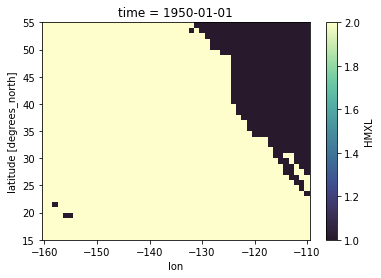

In [64]:
mask_ocean = 2 * np.ones((hmxl.shape[1], hmxl.shape[2])) * np.isfinite(hmxl.isel(time=0))  
mask_land = 1 * np.ones((hmxl.shape[1], hmxl.shape[2])) * np.isnan(hmxl.isel(time=0))  
mask_array = mask_ocean + mask_land
mask_array.plot(cmap=cmocean.cm.deep_r)

## get anomalies and plot -- example cases

In [66]:
#195 - 217 for pnw
start = 5
end = 20
ncases = end - start 

hmxl_anoms = get_anoms(hmxl,tmq_daily.time, start, end, 3, 3, 0)
ssh_anoms = get_anoms(ssh, tmq_daily.time,start, end, 3, 3, 0)
shf_anoms = get_anoms(shf, tmq_daily.time,start, end, 1, 1, 1)
evap_anoms = get_anoms(evap,tmq_daily.time, start, end, 1,1,1)
sen_anoms = get_anoms(sen,tmq_daily.time, start, end, 1,1,1)
sst_anoms = get_anoms(sst,tmq_daily.time,start,end,3,3,0)


0
0
0
0
0
0


#### plot all cases

 doing composite. Even NWP has differnt types of ARs...

In [65]:
tmq_sub = tmq_daily.sel(lat=slice(15,55),lon=slice(-160,-110))
u850_sub = u850_daily.sel(lat=slice(15,55),lon=slice(-160,-110))
v850_sub = v850_daily.sel(lat=slice(15,55),lon=slice(-160,-110))

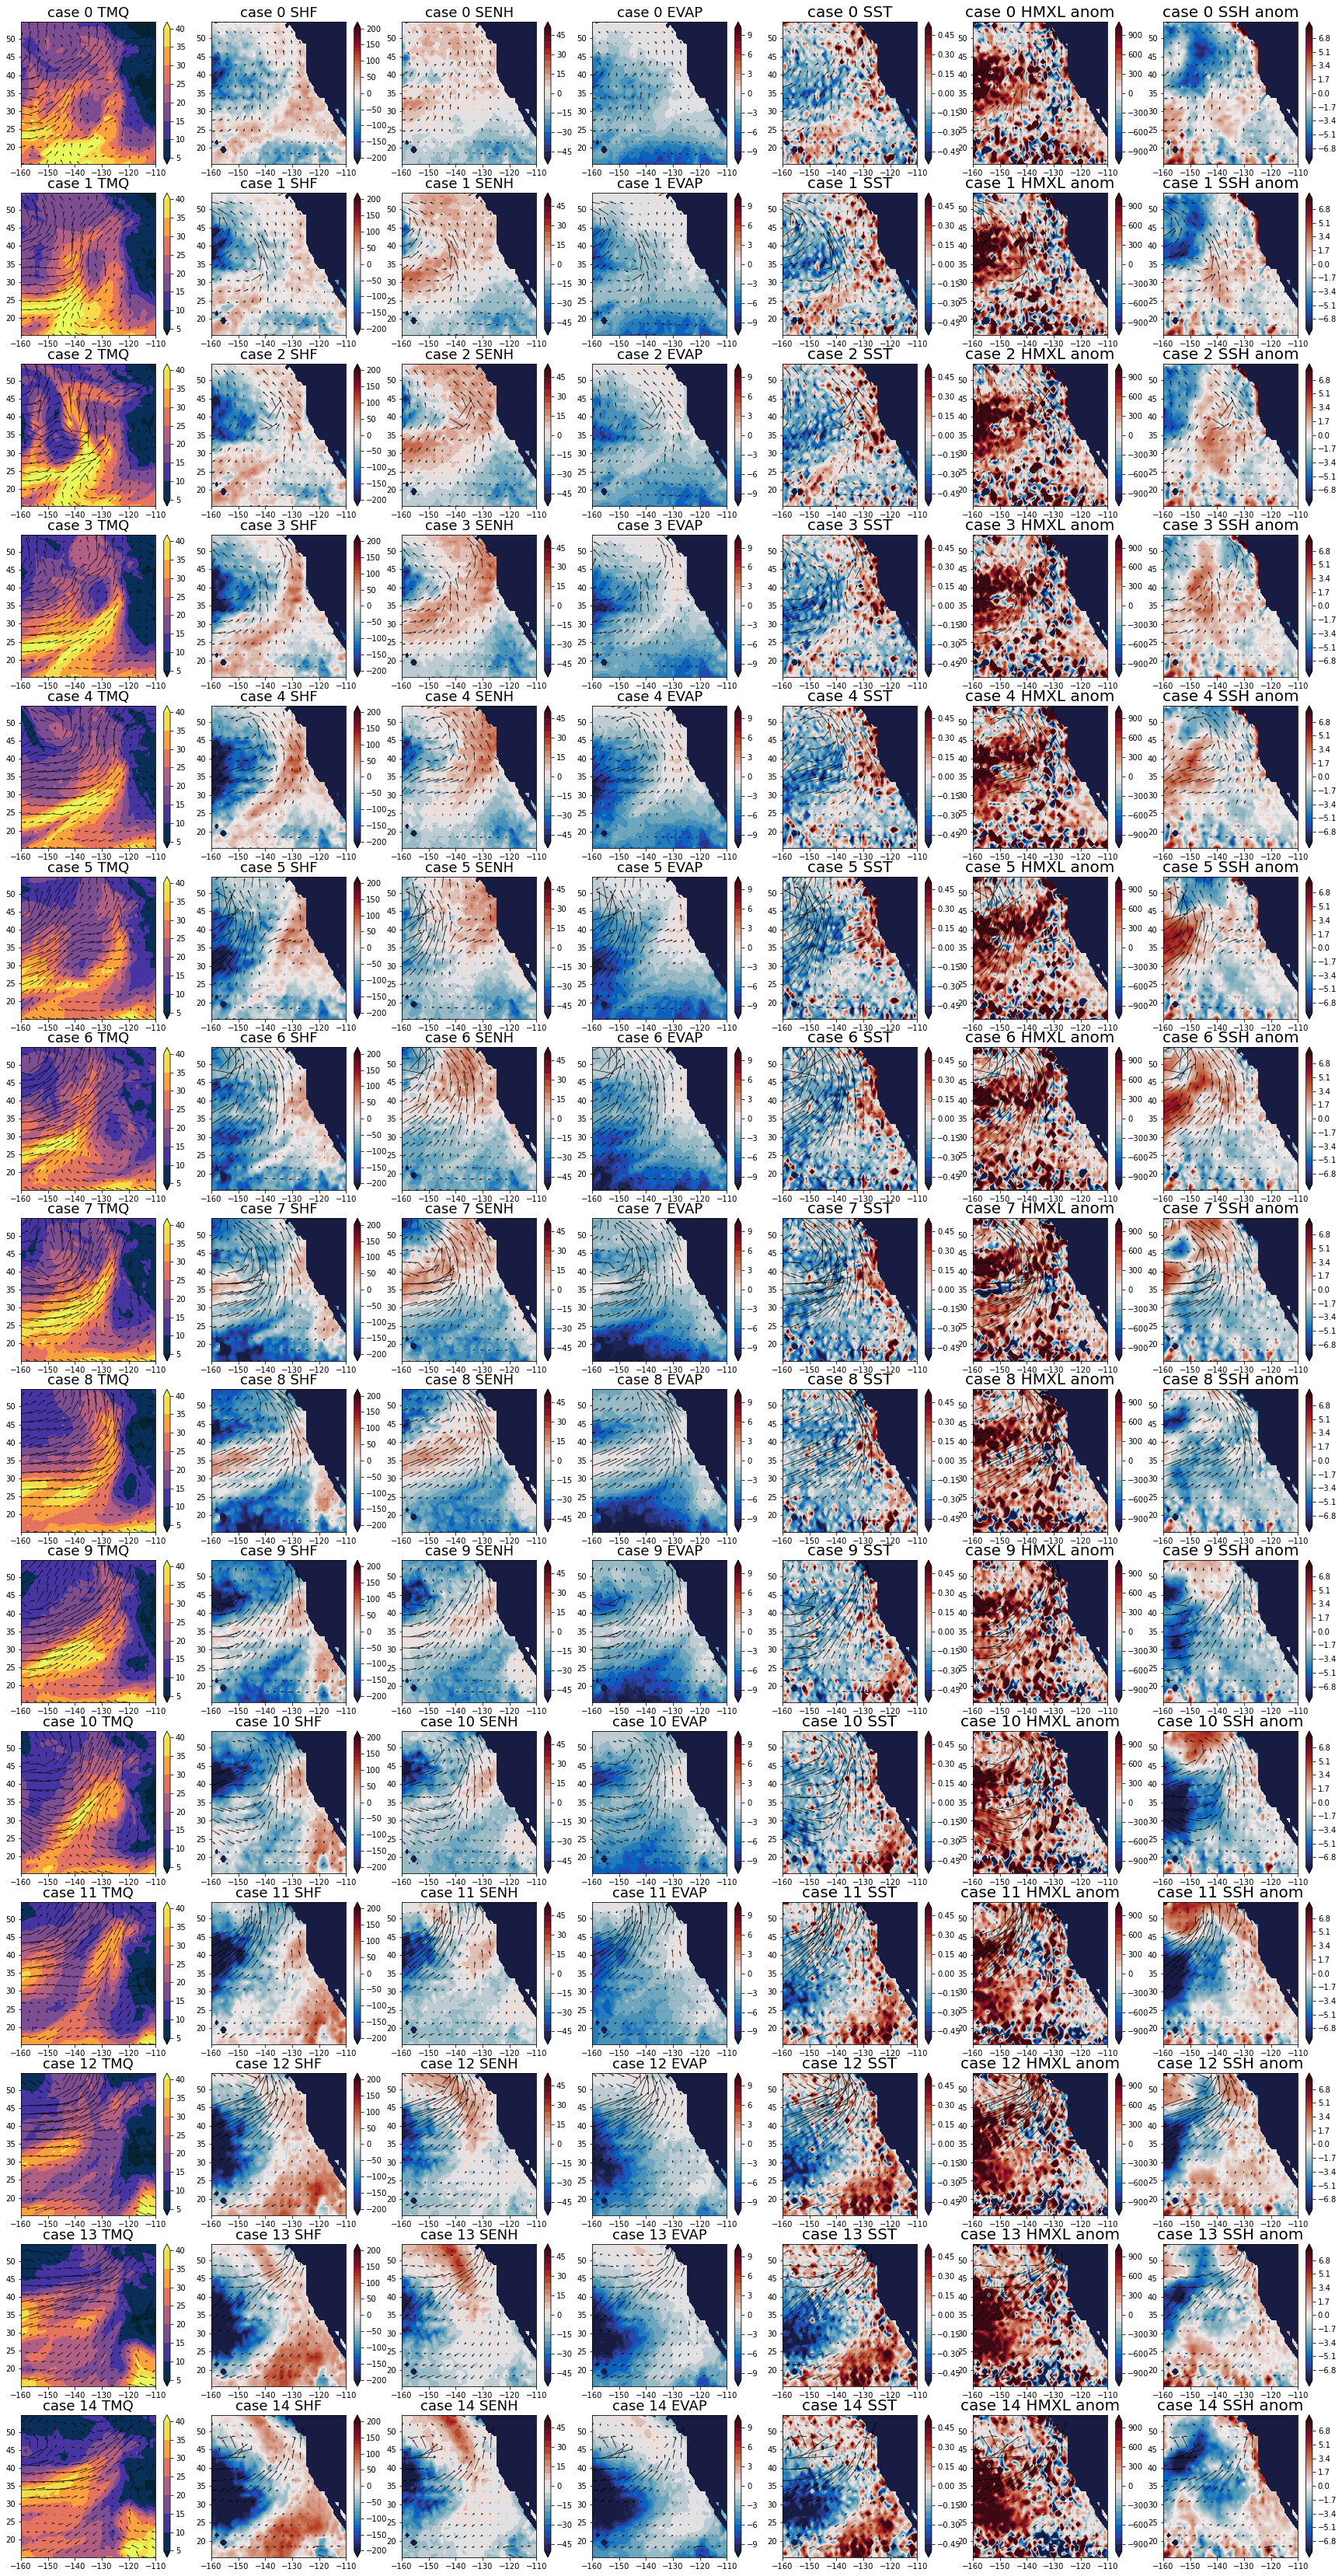

In [67]:
nrows = ncases
ncols =7
start = 0   #from case number 5

levels = np.arange(5,45.,5)
levels1=np.arange(10,800,50)
levels2 = np.arange(-1000,1100,100)

lats= tmq_sub.lat
lons= tmq_sub.lon
lats2 =hmxl_anoms.lat
lons2 = hmxl_anoms.lon
color_map=cmocean.cm.thermal

veclon = tmq_sub.lon[::10]                  #-- only every 2nd vector
veclat = tmq_sub.lat[::10]    

veclon2 = taux.lon[::3]
veclat2 = taux.lat[::3]


u850_space = u850_sub[:,::10,::10]
v850_space = v850_sub[:,::10,::10]


taux_space = taux[:,::3,::3]
tauy_space = tauy[:,::3,::3]


fig, axes = plt.subplots(nrows,ncols,figsize=(30,60))
color_map=cmocean.cm.thermal
 

image= []
j=0
image.append(0)

for i in np.arange(0,ncases,1):

    u850_mean = u850_space.sel(time=tmq_daily.time[i+start])
    v850_mean = v850_space.sel(time=tmq_daily.time[i+start])
    
    taux_mean = taux_space.sel(time=tmq_daily.time[i+start])
    tauy_mean = tauy_space.sel(time=tmq_daily.time[i+start])
    
    image[j] = axes[i,0].contourf(lons,lats,tmq_sub.sel(time=tmq_daily.time[i+start]),levels=levels,extend='both',cmap=cmocean.cm.thermal) 
    axes[i,0].quiver(veclon, veclat, u850_mean, v850_mean,scale=160)
    axes[i,0].set_title('case '+str(i)+' TMQ',fontsize=18)
    fig.colorbar(image[j],ax=axes[i,0], fraction=.1)
    j = j + 1
    image.append(j)
    
    image[j] = axes[i,1].contourf(lons2,lats2,shf_anoms.isel(time=i),levels = np.arange(-200,210, 10),extend='both',cmap=cmocean.cm.balance) 
    axes[i,1].quiver(veclon2, veclat2, taux_mean, tauy_mean,scale=30)
    axes[i,1].set_title('case '+str(i)+' SHF',fontsize=18)
    fig.colorbar(image[j],ax=axes[i,1], fraction=.1)
    j = j+1
    image.append(j)
    

    image[j] = axes[i,2].contourf(lons2,lats2,sen_anoms.isel(time=i),levels = np.arange(-50,55, 5),extend='both',cmap=cmocean.cm.balance) 
    axes[i,2].quiver(veclon2, veclat2, taux_mean, tauy_mean,scale=30)
    axes[i,2].set_title('case '+str(i)+' SENH',fontsize=18)
    fig.colorbar(image[j],ax=axes[i,2], fraction=.1)
    j = j+1
    image.append(j)
    
           
    image[j] = axes[i,3].contourf(lons2,lats2,1e5*evap_anoms.isel(time=i),levels = np.arange(-10,11, 1),extend='both',cmap=cmocean.cm.balance) 
    axes[i,3].quiver(veclon2, veclat2, taux_mean, tauy_mean,scale=30)
    axes[i,3].set_title('case '+str(i)+' EVAP',fontsize=18)
    fig.colorbar(image[j],ax=axes[i,3], fraction=.1)
    j = j+1
    image.append(j)
    
    image[j] = axes[i,4].contourf(lons2,lats2,sst_anoms.isel(time=i),levels = np.arange(-.5,.55, 0.05),extend='both',cmap=cmocean.cm.balance) 
    axes[i,4].quiver(veclon2, veclat2, taux_mean, tauy_mean,scale=20)
    axes[i,4].set_title('case '+str(i)+' SST',fontsize=20)
    fig.colorbar(image[j],ax=axes[i,4], fraction=.1)
    j = j+1
    image.append(j)
    
    
    image[j] = axes[i,5].contourf(lons2,lats2,hmxl_anoms.isel(time=i),levels = levels2,extend='both',cmap=cmocean.cm.balance) 
    axes[i,5].quiver(veclon2, veclat2, taux_mean, tauy_mean,scale=20)
    axes[i,5].set_title('case '+str(i)+' HMXL anom',fontsize=20)
    fig.colorbar(image[j],ax=axes[i,5], fraction=.1)
    j = j+1
    image.append(j)
    
    image[j] = axes[i,6].contourf(lons2,lats2,ssh_anoms.isel(time=i),levels =np.arange(-8., 8.1, 0.1),extend='both',cmap=cmocean.cm.balance) 
    axes[i,6].quiver(veclon2, veclat2, taux_mean, tauy_mean,scale=30)
    axes[i,6].set_title('case '+str(i)+' SSH anom',fontsize=20)
    fig.colorbar(image[j],ax=axes[i,6], fraction=.1)
    j = j+1
    image.append(j)
    
#cs0 = axes[5,0].contourf(lons,lats,tmq_mean,levels = levels,extend='both',cmap=cmocean.cm.thermal)    

#fig.colorbar(cs0,ax = axes[5,0], orientation='horizontal', fraction=.1)
#fig.colorbar(cs1, ax=ax[1])

plt.savefig('AR_cases_ihesp')

# composite analysis
- 1. composite by location, full season vs. winter season
- 2. composite by intensity

### 1. divide region for composites

In [68]:
# lat = 36, 39, 42
socal = landfall_daily.where(landfall_daily<36, drop=True)
cal = landfall_daily.where((landfall_daily>=36) & (landfall_daily<42), drop=True)
pnw= landfall_daily.where(landfall_daily>=42, drop=True)

### 1.1 socal

In [70]:
# for socal
start = 50
end = socal.size
ncases = end - start

hmxl_socal_anom = dask.delayed(get_anoms)(hmxl,socal.time, start, end, 3, 3, 0)
ssh_socal_anom = dask.delayed(get_anoms)(ssh, socal.time,start, end, 3, 3, 0)
shf_socal_anom = dask.delayed(get_anoms)(shf, socal.time,start, end, 1, 1, 1)
evap_socal_anom = dask.delayed(get_anoms)(evap,socal.time, start, end, 1,1,1)
sen_socal_anom = dask.delayed(get_anoms)(sen,socal.time, start, end, 1,1,1)
sst_socal_anom = dask.delayed(get_anoms)(sst,socal.time,start,end,3,3,0)


In [73]:
#composite
u850_socal = u850_space.sel(time=socal.time[start:end]).mean('time').compute()
v850_socal = v850_space.sel(time=socal.time[start:end]).mean('time').compute()
tmq_socal = tmq_sub.sel(time=socal.time[start:end]).mean('time').compute()

taux_socal = taux_space.sel(time=socal.time[start:end]).mean('time').compute()
tauy_socal = tauy_space.sel(time=socal.time[start:end]).mean('time').compute()

    
#taux_mean = taux_space.sel(time=pnw.time[i+start])
#tauy_mean = tauy_space.sel(time=pnw.time[i+start])


In [74]:

hmxl_socal = hmxl_socal_anom.mean('time').compute()
ssh_socal = ssh_socal_anom.mean('time').compute()
sst_socal = sst_socal_anom.mean('time').compute()
shf_socal = shf_socal_anom.mean('time').compute()
evap_socal = evap_socal_anom.mean('time').compute()
sen_socal = sen_socal_anom.mean('time').compute()

### 1.1.1 cases socal

### 1.1.2 plot socal composite

In [ ]:
# shf, sen and evap needs to be compared with long-term mean climatology
shf_socal_anomclm = shf_socal - shf.mean('time')
sen_socal_anomclm = sen_socal - sen.mean('time')
evap_socal_anomclm = evap_socal - evap.mean('time')

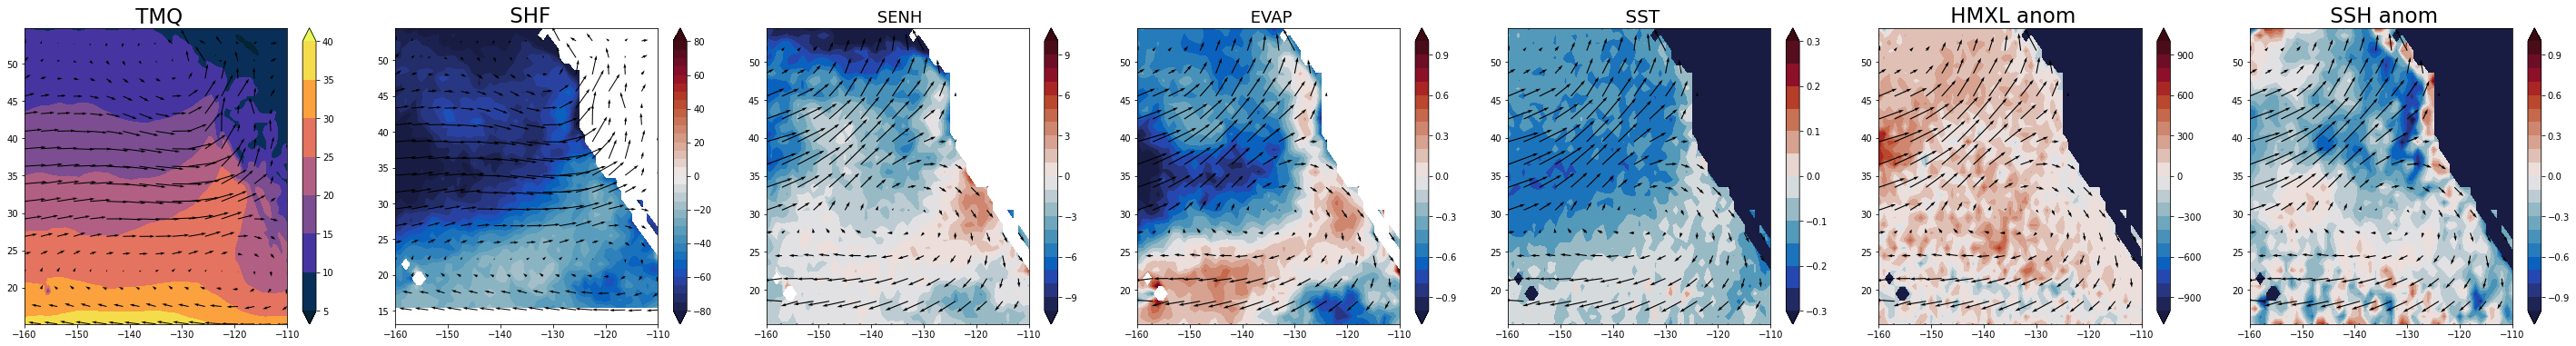

In [124]:
    
nrows = 1
ncols = 7
fig, axes = plt.subplots(nrows, ncols,figsize=(50,6))


cs0c = axes[0].contourf(lons,lats,tmq_socal, levels=levels,extend='both',cmap=cmocean.cm.thermal) 
cs0q = axes[0].quiver(veclon, veclat, u850_socal, v850_socal,scale=100)
axes[0].set_title(' TMQ',fontsize=23)
fig.colorbar(cs0c,ax=axes[0], fraction=.1)


cs1c = axes[1].contourf(lons2, lats2, shf_socal_anomclm, levels = np.arange(-80,85, 5),extend='both',cmap=cmocean.cm.balance) 
cs1q = axes[1].quiver(veclon, veclat, u850_socal, v850_socal,scale=100)
axes[1].set_title(' SHF',fontsize=23)
fig.colorbar(cs1c,ax=axes[1], fraction=.1)

cs2c = axes[2].contourf(lons2,lats2,sen_socal_anomclm,levels = np.arange(-10,11, 1),extend='both',cmap=cmocean.cm.balance)
cs2q = axes[2].quiver(veclon2, veclat2, taux_socal, tauy_socal,scale=10)
axes[2].set_title(' SENH',fontsize=18)
fig.colorbar(cs2c,ax=axes[2], fraction=.1)
    
           
cs3c = axes[3].contourf(lons2,lats2,1e5*evap_socal_anomclm,levels = np.arange(-1,1.1, 0.1),extend='both',cmap=cmocean.cm.balance) 
cs3q = axes[3].quiver(veclon2, veclat2, taux_socal, tauy_socal,scale=10)
axes[3].set_title(' EVAP',fontsize=18)
fig.colorbar(cs3c,ax=axes[3], fraction=.1)

    
cs4c = axes[4].contourf(lons2,lats2,sst_socal,levels = np.arange(-.3,.35, 0.05),extend='both',cmap=cmocean.cm.balance) 
cs4q = axes[4].quiver(veclon2, veclat2, taux_socal, tauy_socal,scale=10)
axes[4].set_title(' SST',fontsize=20)
fig.colorbar(cs4c,ax=axes[4], fraction=.1)
    
    
cs5c =  axes[5].contourf(lons2,lats2,hmxl_socal, levels = levels2,extend='both',cmap=cmocean.cm.balance) 
cs5q =  axes[5].quiver(veclon2, veclat2, taux_socal, tauy_socal,scale=10)
axes[5].set_title(' HMXL anom',fontsize=23)
fig.colorbar(cs5c,ax=axes[5], fraction=.1)
    
cs6c = axes[6].contourf(lons2,lats2,ssh_socal,levels =np.arange(-1.,1.1, 0.1),extend='both',cmap=cmocean.cm.balance) 
cs6q = axes[6].quiver(veclon2, veclat2, taux_socal, tauy_socal,scale=10)
axes[6].set_title(' SSH anom',fontsize=23)
fig.colorbar(cs6c,ax=axes[6], fraction=.1)

plt.savefig('AR_comp_socal')

## 1.2 composite pnw

In [105]:
# get anoms

start = 50
end = pnw.size
ncases = end - start

hmxl_pnw_anom = dask.delayed(get_anoms)(hmxl,pnw.time, start, end, 3, 3, 0)
ssh_pnw_anom = dask.delayed(get_anoms)(ssh, pnw.time,start, end, 3, 3, 0)
shf_pnw_anom = dask.delayed(get_anoms)(shf, pnw.time,start, end, 1, 1, 1)
evap_pnw_anom = dask.delayed(get_anoms)(evap,pnw.time, start, end, 1,1,1)
sen_pnw_anom = dask.delayed(get_anoms)(sen,pnw.time, start, end, 1,1,1)
sst_pnw_anom = dask.delayed(get_anoms)(sst,pnw.time,start,end,3,3,0)

In [106]:
u850_pnw = u850_space.sel(time=pnw.time[start:end]).mean('time').compute()
v850_pnw = v850_space.sel(time=pnw.time[start:end]).mean('time').compute()
tmq_pnw = tmq_sub.sel(time=pnw.time[start:end]).mean('time').compute()

In [107]:

hmxl_pnw = hmxl_pnw_anom.mean('time').compute()
ssh_pnw = ssh_pnw_anom.mean('time').compute()
sst_pnw = sst_pnw_anom.mean('time').compute()
shf_pnw = shf_pnw_anom.mean('time').compute()
evap_pnw = evap_pnw_anom.mean('time').compute()
sen_pnw = sen_pnw_anom.mean('time').compute()

In [110]:
# to deal with dates that are in pnw, but not in taux
pnw_sub = pnw.where(pnw.time.isin(taux_space.time),drop=True)
taux_pnw = taux_space.sel(time=pnw_sub.time[start:end]).mean('time').compute()
tauy_pnw = tauy_space.sel(time=pnw_sub.time[start:end]).mean('time').compute()

In [111]:
# shf, sen and evap needs to be compared with long-term mean climatology
shf_pnw_anomclm = shf_pnw - shf.mean('time')
sen_pnw_anomclm = sen_pnw - sen.mean('time')
evap_pnw_anomclm = evap_pnw - evap.mean('time')

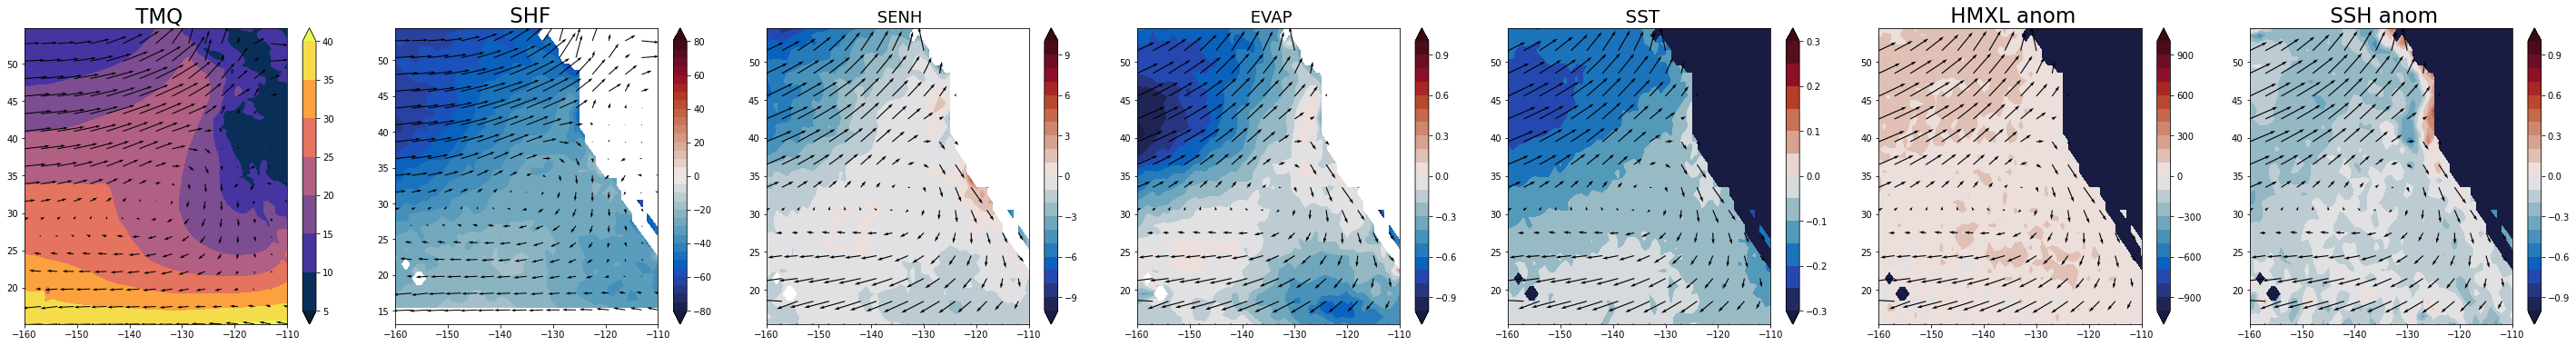

In [123]:
    
nrows = 1
ncols = 7
fig, axes = plt.subplots(nrows, ncols,figsize=(50,6))


cs0c = axes[0].contourf(lons,lats,tmq_pnw, levels=levels,extend='both',cmap=cmocean.cm.thermal) 
cs0q = axes[0].quiver(veclon, veclat, u850_pnw, v850_pnw,scale=100)
axes[0].set_title(' TMQ',fontsize=23)
fig.colorbar(cs0c,ax=axes[0], fraction=.1)

cs1c = axes[1].contourf(lons2, lats2, shf_pnw_anomclm, levels = np.arange(-80,85, 5),extend='both',cmap=cmocean.cm.balance) 
cs1q = axes[1].quiver(veclon, veclat, u850_pnw, v850_pnw,scale=100)
axes[1].set_title(' SHF',fontsize=23)
fig.colorbar(cs1c,ax=axes[1], fraction=.1)

cs2c = axes[2].contourf(lons2,lats2,sen_pnw_anomclm,levels = np.arange(-10,11, 1),extend='both',cmap=cmocean.cm.balance)
cs2q = axes[2].quiver(veclon2, veclat2, taux_pnw, tauy_pnw,scale=10)
axes[2].set_title(' SENH',fontsize=18)
fig.colorbar(cs2c,ax=axes[2], fraction=.1)
    
           
cs3c = axes[3].contourf(lons2,lats2,1e5*evap_pnw_anomclm,levels = np.arange(-1,1.1, 0.1),extend='both',cmap=cmocean.cm.balance) 
cs3q = axes[3].quiver(veclon2, veclat2, taux_pnw, tauy_pnw,scale=10)
axes[3].set_title(' EVAP',fontsize=18)
fig.colorbar(cs3c,ax=axes[3], fraction=.1)

    
cs4c = axes[4].contourf(lons2,lats2,sst_pnw,levels = np.arange(-.3,.35, 0.05),extend='both',cmap=cmocean.cm.balance) 
cs4q = axes[4].quiver(veclon2, veclat2, taux_pnw, tauy_pnw,scale=10)
axes[4].set_title(' SST',fontsize=20)
fig.colorbar(cs4c,ax=axes[4], fraction=.1)
    
    
cs5c =  axes[5].contourf(lons2,lats2,hmxl_pnw, levels = levels2,extend='both',cmap=cmocean.cm.balance) 
cs5q =  axes[5].quiver(veclon2, veclat2, taux_pnw, tauy_pnw,scale=10)
axes[5].set_title(' HMXL anom',fontsize=23)
fig.colorbar(cs5c,ax=axes[5], fraction=.1)
    
cs6c = axes[6].contourf(lons2,lats2,ssh_pnw,levels =np.arange(-1.,1.1, 0.1),extend='both',cmap=cmocean.cm.balance) 
cs6q = axes[6].quiver(veclon2, veclat2, taux_pnw, tauy_pnw,scale=10)
axes[6].set_title(' SSH anom',fontsize=23)
fig.colorbar(cs6c,ax=axes[6], fraction=.1)

plt.savefig('AR_comp_pnw')

### 1.3. composite northern california

In [116]:
# get anoms

start = 50
end = cal.size
ncases = end - start

hmxl_cal_anom = dask.delayed(get_anoms)(hmxl,cal.time, start, end, 3, 3, 0)
ssh_cal_anom = dask.delayed(get_anoms)(ssh, cal.time,start, end, 3, 3, 0)
shf_cal_anom = dask.delayed(get_anoms)(shf, cal.time,start, end, 1, 1, 1)
evap_cal_anom = dask.delayed(get_anoms)(evap,cal.time, start, end, 1,1,1)
sen_cal_anom = dask.delayed(get_anoms)(sen,cal.time, start, end, 1,1,1)
sst_cal_anom = dask.delayed(get_anoms)(sst,cal.time,start,end,3,3,0)

In [117]:
u850_cal = u850_space.sel(time=cal.time[start:end]).mean('time').compute()
v850_cal = v850_space.sel(time=cal.time[start:end]).mean('time').compute()
tmq_cal = tmq_sub.sel(time=cal.time[start:end]).mean('time').compute()

In [118]:

hmxl_cal = hmxl_cal_anom.mean('time').compute()
ssh_cal = ssh_cal_anom.mean('time').compute()
sst_cal = sst_cal_anom.mean('time').compute()
shf_cal = shf_cal_anom.mean('time').compute()
evap_cal = evap_cal_anom.mean('time').compute()
sen_cal = sen_cal_anom.mean('time').compute()

In [119]:
# to deal with dates that are in cal, but not in taux
cal_sub = cal.where(cal.time.isin(taux_space.time),drop=True)
taux_cal = taux_space.sel(time=cal_sub.time[start:end]).mean('time').compute()
tauy_cal = tauy_space.sel(time=cal_sub.time[start:end]).mean('time').compute()

In [120]:
# shf, sen and evap needs to be compared with long-term mean climatology
shf_cal_anomclm = shf_cal - shf.mean('time')
sen_cal_anomclm = sen_cal - sen.mean('time')
evap_cal_anomclm = evap_cal - evap.mean('time')

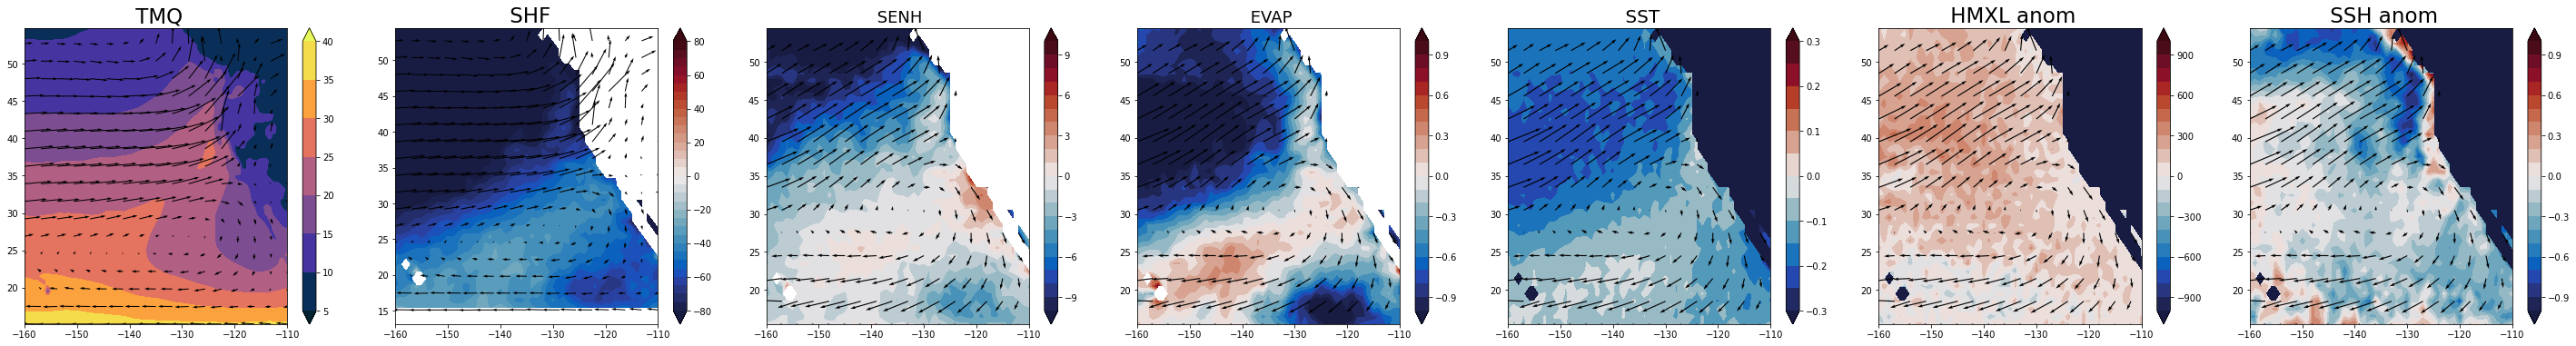

In [122]:
    
nrows = 1
ncols = 7
fig, axes = plt.subplots(nrows, ncols,figsize=(50,6))


cs0c = axes[0].contourf(lons,lats,tmq_cal, levels=levels,extend='both',cmap=cmocean.cm.thermal) 
cs0q = axes[0].quiver(veclon, veclat, u850_cal, v850_cal,scale=100)
axes[0].set_title(' TMQ',fontsize=23)
fig.colorbar(cs0c,ax=axes[0], fraction=.1)

cs1c = axes[1].contourf(lons2, lats2, shf_cal_anomclm, levels = np.arange(-80,85, 5),extend='both',cmap=cmocean.cm.balance) 
cs1q = axes[1].quiver(veclon, veclat, u850_cal, v850_cal,scale=100)
axes[1].set_title(' SHF',fontsize=23)
fig.colorbar(cs1c,ax=axes[1], fraction=.1)

cs2c = axes[2].contourf(lons2,lats2,sen_cal_anomclm,levels = np.arange(-10,11, 1),extend='both',cmap=cmocean.cm.balance)
cs2q = axes[2].quiver(veclon2, veclat2, taux_cal, tauy_cal,scale=10)
axes[2].set_title(' SENH',fontsize=18)
fig.colorbar(cs2c,ax=axes[2], fraction=.1)
    
           
cs3c = axes[3].contourf(lons2,lats2,1e5*evap_cal_anomclm,levels = np.arange(-1,1.1, 0.1),extend='both',cmap=cmocean.cm.balance) 
cs3q = axes[3].quiver(veclon2, veclat2, taux_cal, tauy_cal,scale=10)
axes[3].set_title(' EVAP',fontsize=18)
fig.colorbar(cs3c,ax=axes[3], fraction=.1)

    
cs4c = axes[4].contourf(lons2,lats2,sst_cal,levels = np.arange(-.3,.35, 0.05),extend='both',cmap=cmocean.cm.balance) 
cs4q = axes[4].quiver(veclon2, veclat2, taux_cal, tauy_cal,scale=10)
axes[4].set_title(' SST',fontsize=20)
fig.colorbar(cs4c,ax=axes[4], fraction=.1)
    
    
cs5c =  axes[5].contourf(lons2,lats2,hmxl_cal, levels = levels2,extend='both',cmap=cmocean.cm.balance) 
cs5q =  axes[5].quiver(veclon2, veclat2, taux_cal, tauy_cal,scale=10)
axes[5].set_title(' HMXL anom',fontsize=23)
fig.colorbar(cs5c,ax=axes[5], fraction=.1)
    
cs6c = axes[6].contourf(lons2,lats2,ssh_cal,levels =np.arange(-1.,1.1, 0.1),extend='both',cmap=cmocean.cm.balance) 
cs6q = axes[6].quiver(veclon2, veclat2, taux_cal, tauy_cal,scale=10)
axes[6].set_title(' SSH anom',fontsize=23)
fig.colorbar(cs6c,ax=axes[6], fraction=.1)

plt.savefig('AR_comp_cal')